## Creating DC2 Templates

Loading Brown et al. templates with emission lines masked we will attempt to extrapolate in color space and create new templates that better span the color space of DC2 galaxies. To do the extrapolation we will use [ESP](https://github.com/jbkalmbach/ESP).

### Load templates and perform PCA

In [100]:
import esp
import os
import numpy as np
import GCRCatalogs
from copy import deepcopy
from matplotlib import pyplot as plt
from lsst.sims.photUtils import BandpassDict, Bandpass, Sed
%matplotlib inline

Here we load the Brown templates from the data directory.

In [2]:
brown_data_dir = '../../data/brown_templates/'
pca_obj = esp.pcaSED()
pca_obj.load_full_spectra(brown_data_dir)

File On 100 out of 129
Done loading spectra from file


In [3]:
new_spec_list = []
for sed_obj in pca_obj.spec_list_orig:
    new_sed_obj = deepcopy(sed_obj)
    new_sed_obj.wavelen = new_sed_obj.wavelen/10. #Convert to nanometers
    new_spec_list.append(new_sed_obj)
pca_obj.spec_list_orig = new_spec_list

Now we perform PCA on the templates truncating them at 1200.0 nanometers and keeping 10 components

In [5]:
pca_obj.PCA(minWavelen=1., maxWavelen=1200., comps=10)

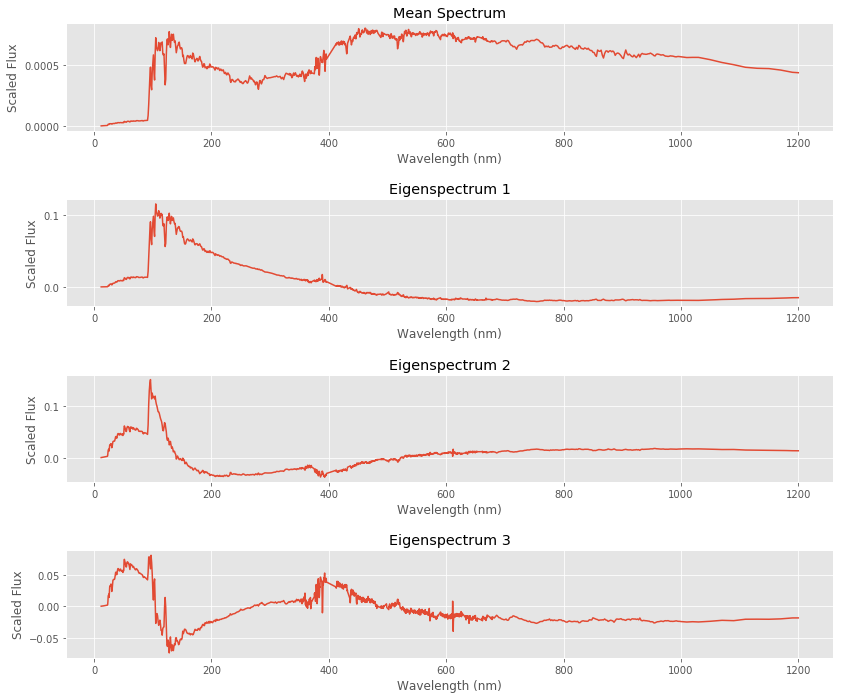

In [6]:
plotter = esp.plotUtils()
fig = plt.figure(figsize=(12, 10))
fig = plotter.plot_eigenspectra(pca_obj, 3, fig = fig)

In [9]:
### If there is already a folder for storing the PCA information uncomment below
#! rm -rf brown_pca

In [10]:
os.mkdir('brown_pca')
pca_obj.write_output('brown_pca')

### Load the DC2 data from `gcr_catalogs`

In [11]:
catalog = GCRCatalogs.load_catalog('cosmoDC2_v0.1_test')

In [12]:
### To see a list of all the possible quantities uncomment below
#print(sorted(catalog.list_all_quantities()))

In [13]:
new_pca_obj = esp.pcaSED()
new_pca_obj.load_pca_output('brown_pca')

Here we will load in the LSST z=0 magnitudes of the cosmoDC2 galaxies.

In [14]:
data = catalog.get_quantities(['Mag_true_u_lsst_z0', 'Mag_true_g_lsst_z0', 'Mag_true_r_lsst_z0',
                               'Mag_true_i_lsst_z0', 'Mag_true_z_lsst_z0', 'Mag_true_Y_lsst_z0'])

In [15]:
data

{'Mag_true_z_lsst_z0': array([-21.25825691, -17.87758827, -19.53742981, ..., -18.4183197 ,
        -17.93312836, -18.77084351], dtype=float32),
 'Mag_true_Y_lsst_z0': array([-21.39706039, -17.96505165, -19.63167381, ..., -18.44379616,
        -17.94452858, -18.80664635], dtype=float32),
 'Mag_true_r_lsst_z0': array([-20.62280846, -17.32863426, -19.12031937, ..., -18.44831085,
        -17.93710899, -18.66314697], dtype=float32),
 'Mag_true_g_lsst_z0': array([-19.93616676, -16.71219826, -18.67207336, ..., -18.41373634,
        -17.93239403, -18.47358513], dtype=float32),
 'Mag_true_i_lsst_z0': array([-21.02715492, -17.69902802, -19.35670471, ..., -18.44402695,
        -17.94334602, -18.7437973 ], dtype=float32),
 'Mag_true_u_lsst_z0': array([-18.40675545, -15.36780167, -17.70329666, ..., -17.88930511,
        -17.43955994, -17.70584297], dtype=float32)}

In [16]:
len(data['Mag_true_Y_lsst_z0'])

74624751

In order to keep the dataset a reasonable size in the Gaussian Process below we will thin it out by a factor of 10000. This should still provide a representative color range of the full dataset. We do this and calculate the colors from the magnitudes in the step below.

In [17]:
colors = []
for i in range(0,len(data['Mag_true_Y_lsst_z0']), 10000):
    single_gal = []
    for band in ['u', 'g', 'r', 'i', 'z', 'Y']:
        single_gal.append(data['Mag_true_%s_lsst_z0' % band][i])
    single_gal = np.array(single_gal)
    colors.append(single_gal[:-1] - single_gal[1:])
lsst_dc2_colors = np.array(colors)

In [19]:
# Load the LSST bandpasses
lsst_bandpass_dict = BandpassDict.loadTotalBandpassesFromFiles()

Here we calculate the template colors in the LSST bandpasses and compare to the cosmoDC2 galaxies.

In [20]:
lsst_template_colors = new_pca_obj.calc_colors(lsst_bandpass_dict, 10)

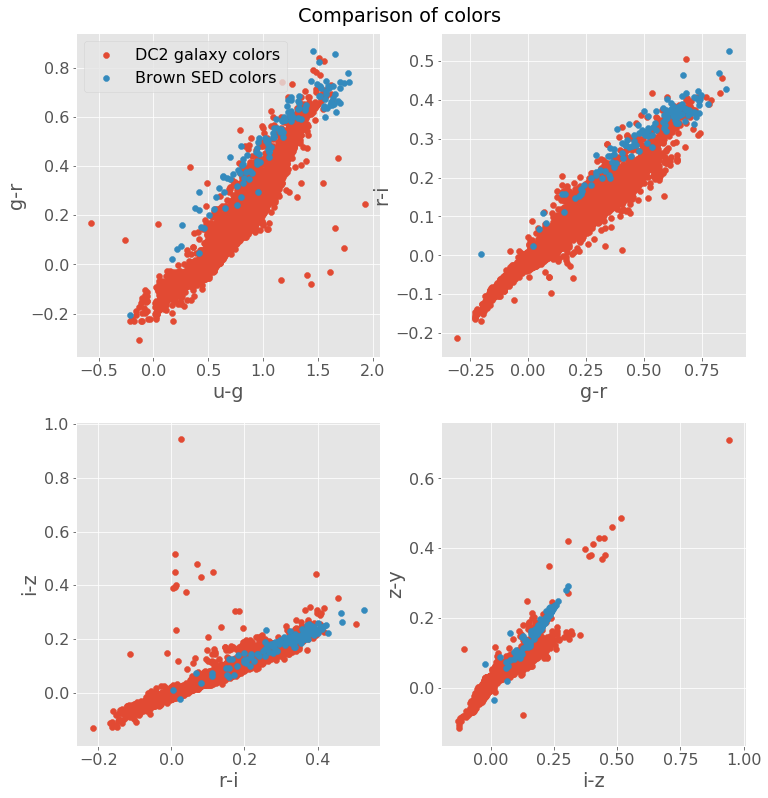

In [21]:
fig = plt.figure(figsize=(12,12))
color_labels = ['u-g', 'g-r', 'r-i', 'i-z', 'z-y']
for i in range(4):
    col_0 = i
    col_1 = i+1
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,col_0], lsst_dc2_colors[:,col_1], label='DC2 galaxy colors')
    plt.scatter(lsst_template_colors[:,col_0], lsst_template_colors[:,col_1], label='Brown SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 0:
        plt.legend()
plt.suptitle('Comparison of colors')
plt.subplots_adjust(top=0.95)

### Run the Gaussian Process method from ESP in the color space to generate new templates.

What we are doing below is fitting a Gaussian process for the PCA coefficients of the templates to their locations in the LSST color space. Then for every cosmoDC2 color we are predicting PCA cofficients for those locations in color space. Using these PCA coefficients we then reconstruct a spectrum for that color location and recalculate the color of the new "template". Below we compare how well the extrapolated template reproduces the input colors at that location.

In [51]:
gp_obj = esp.gaussianProcessEstimate(new_pca_obj, lsst_bandpass_dict, lsst_dc2_colors)

In [52]:
gp_kernel = gp_obj.define_kernel('exp', 1.0e-3, 1.0e-3, n_dim=len(lsst_dc2_colors[0]))

In [53]:
gp_spec = gp_obj.gp_predict(gp_kernel, opt_bandpass_dict=lsst_bandpass_dict)

In [54]:
lsst_gp_colors = gp_spec.calc_colors(lsst_bandpass_dict, 10)

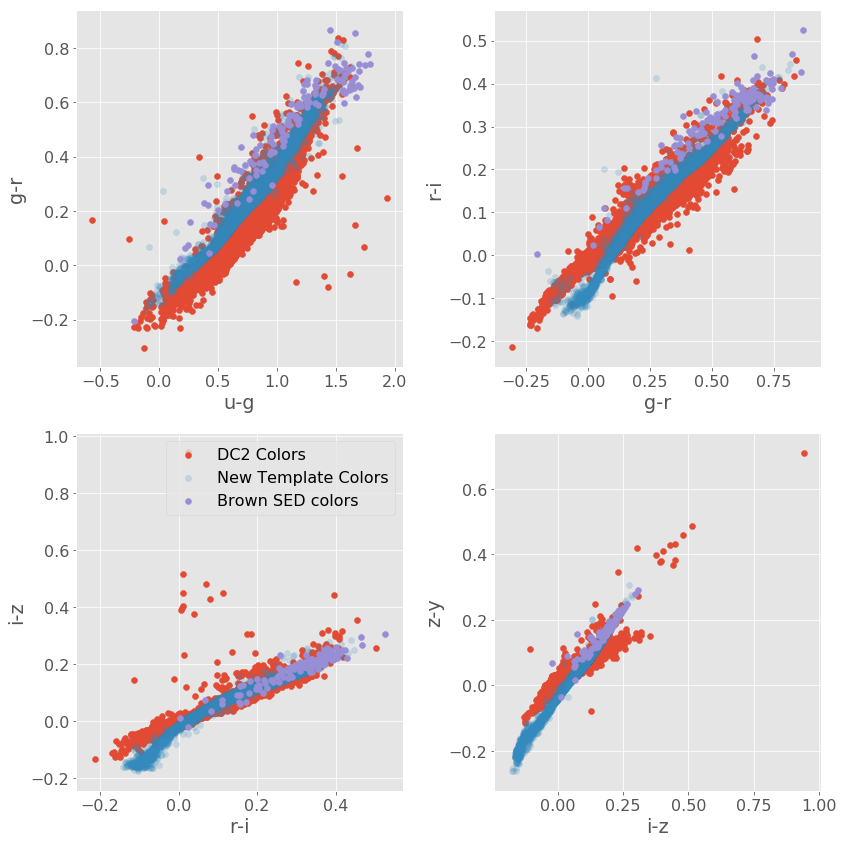

In [55]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,i], lsst_dc2_colors[:,i+1], label='DC2 Colors')
    plt.scatter(lsst_gp_colors[:,i], lsst_gp_colors[:,i+1], alpha=0.2, label='New Template Colors')
    plt.scatter(lsst_template_colors[:,i], lsst_template_colors[:,i+1], label='Brown SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()

Compare how closely we are able to reconstruct the colors for each cosmoDC2 galaxy with a new template.

In [50]:
#m32_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

In [39]:
#m52_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

In [33]:
#sq_exp_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

In [56]:
exp_gp_lsst = np.sqrt(np.sum(np.square(lsst_gp_colors - lsst_dc2_colors), axis=1))

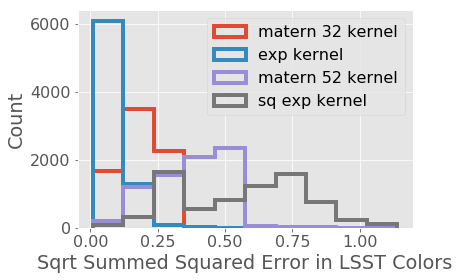

In [57]:
n, bins, _ = plt.hist(m32_gp_lsst, histtype='step', label='matern 32 kernel', lw=4)
plt.hist(exp_gp_lsst, bins=bins, histtype='step', label='exp kernel', lw=4)
plt.hist(m52_gp_lsst, bins=bins, histtype='step', label='matern 52 kernel', lw=4)
plt.hist(sq_exp_gp_lsst, bins=bins, histtype='step', label='sq exp kernel', lw=4)
plt.legend()
plt.xlabel('Sqrt Summed Squared Error in LSST Colors')
plt.ylabel('Count')

In [58]:
np.exp(gp_spec.params)

array([[  2.08644111e-04,   6.29240716e+02],
       [  6.46009462e-05,   7.03203353e+02],
       [  6.18191169e-06,   1.89692509e+01],
       [  2.89915237e-06,   1.05006535e+02],
       [  1.16525997e-07,   4.07826120e-02],
       [  4.99719765e-08,   1.24007111e-03],
       [  1.13618502e-06,   3.65350863e+01],
       [  2.66512576e-07,   2.55791444e+00],
       [  3.90465327e-08,   2.24985622e-02],
       [  1.43244282e-08,   1.27179026e-07]])

It seems that we should use the Exponential kernel to create our templates.

### Pick the new templates that most accurately recreate the input colors to use as a new set of templates.

First we will find the 5000 new templates that best recreate the input colors from cosmoDC2 galaxies.

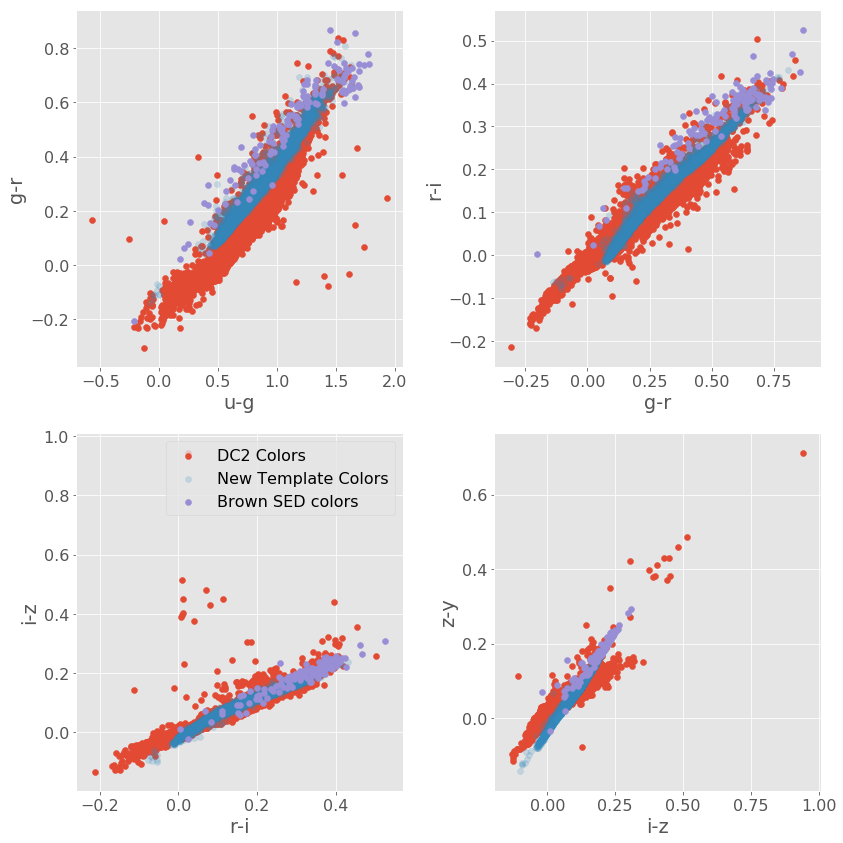

In [68]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,i], lsst_dc2_colors[:,i+1], label='DC2 Colors')
    plt.scatter(lsst_gp_colors[min_err_idx,i], lsst_gp_colors[min_err_idx,i+1], alpha=0.2, label='New Template Colors')
    plt.scatter(lsst_template_colors[:,i], lsst_template_colors[:,i+1], label='Brown SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()

Next we will cluster these high-grade templates into 50 clusters in color space to get a good spread of new locations for new templates. Then we will randomly choose one template from each cluster and use the PCA coefficients for these points in color space to generate a new set of 50 templates to complement the Brown templates.

In [70]:
from sklearn.cluster import KMeans

In [86]:
rand_state = np.random.RandomState(3213)
kmeans = KMeans(n_clusters = 50, random_state=rand_state).fit(lsst_gp_colors[min_err_idx])

In [87]:
new_template_idx = []
for cluster_num in range(50):
    cluster_idx = np.where(kmeans.labels_ == cluster_num)[0]
    new_template_idx.append(rand_state.choice(min_err_idx[cluster_idx]))

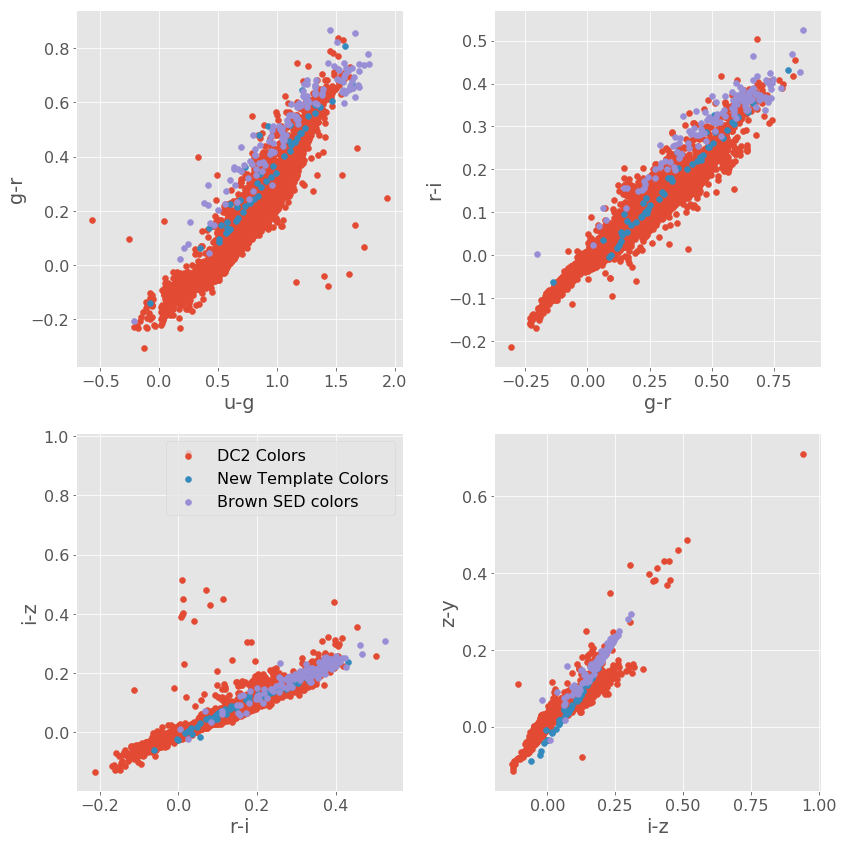

In [88]:
fig = plt.figure(figsize=(12,12))
for i in range(4):
    fig.add_subplot(2,2,i+1)
    plt.scatter(lsst_dc2_colors[:,i], lsst_dc2_colors[:,i+1], label='DC2 Colors')
    plt.scatter(lsst_gp_colors[cluster_keep_idx,i], lsst_gp_colors[cluster_keep_idx,i+1], label='New Template Colors')
    plt.scatter(lsst_template_colors[:,i], lsst_template_colors[:,i+1], label='Brown SED colors')
    plt.xlabel(color_labels[i])
    plt.ylabel(color_labels[i+1])
    if i == 2:
        plt.legend()
plt.tight_layout()

In [91]:
new_templates = gp_spec.reconstruct_spectra(10)[new_template_idx]

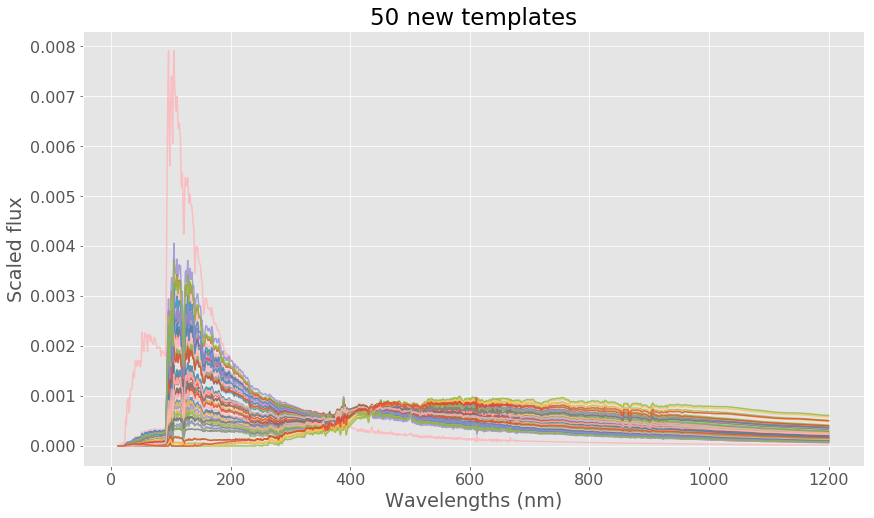

In [98]:
fig = plt.figure(figsize=(14, 8))
for i in range(50):
    plt.plot(new_pca_obj.wavelengths, new_templates[i], alpha=0.8)
plt.xlabel('Wavelengths (nm)')
plt.ylabel('Scaled flux')
plt.title('50 new templates')

In [112]:
### To write the new templates to file:
# (Changed to be written in angstroms to be consistent with Brown templates given)
template_folder = 'new_templates'
os.mkdir(template_folder)
sed_names = []
spec_on = 0
for sed_obj in new_templates:
    with open(os.path.join(template_folder, '%i.sed' % spec_on), 'w') as f:
        f.write('# Wavelength(angstrom)  Flambda(ergs/cm^s/s/angstrom)\n')
        for line_idx in range(len(new_pca_obj.wavelengths)):
            print(10.*new_pca_obj.wavelengths[line_idx], 0.1*sed_obj[line_idx], file=f)
    spec_on += 1